In [6]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

# Data Summary

In [7]:
import pandas as pd
import numpy as np

# Join and group by SchoolCode in SQL
school_level_query = """
    SELECT 
        c.SchoolCode,
        c.DistrictCode,
        c.CountyCode,
        c.Charter,
        AVG(c."TOTAL_ENR.TA") as avg_enrollment,
        AVG(a."RegHSDiploma.TA") as avg_graduates,
        AVG(a."CohortStudents.TA") as avg_cohort,
        AVG(a."RegHSDiploma.TA" * 1.0 / NULLIF(a."CohortStudents.TA", 0)) as avg_graduation_rate,
        COUNT(DISTINCT c.AcademicYear) as num_years_data
    FROM CensusDayWide c
    JOIN ACGRWide a
    ON c.SchoolCode = a.SchoolCode 
    AND c.AcademicYear = a.Year
    GROUP BY c.SchoolCode, c.DistrictCode, c.CountyCode, c.Charter
    ORDER BY avg_enrollment DESC
"""

school_analysis = pd.read_sql_query(school_level_query, con)
school_analysis

,SchoolCode,DistrictCode,CountyCode,Charter,avg_enrollment,avg_graduates,avg_cohort,avg_graduation_rate,num_years_data
0,130757,76505,34,Y,9069.000000,90.000000,3631.000000,0.024787,1
1,110833,10330,33,Y,7548.000000,180.000000,205.000000,0.878049,1
2,3430717,67447,34,Y,7009.000000,1149.000000,1436.000000,0.800139,1
3,134312,63628,15,Y,6931.000000,201.000000,218.000000,0.922018,1
4,110833,10330,33,None,6661.888889,167.888889,201.611111,0.833962,6
...,...,...,...,...,...,...,...,...,...
5485,5030184,73601,50,None,1.444444,NaN,NaN,NaN,3
5486,110858,63891,16,N,1.000000,NaN,NaN,NaN,1
5487,141648,73437,19,N,1.000000,NaN,NaN,NaN,1
5488,2330223,73916,23,None,1.000000,NaN,NaN,NaN,1


In [8]:
acgr_to_census_mapping = {
    # Race/Ethnicity
    'RB': 'RE_B',  # African American
    'RI': 'RE_I',  # American Indian or Alaska Native
    'RA': 'RE_A',  # Asian
    'RF': 'RE_F',  # Filipino
    'RH': 'RE_H',  # Hispanic or Latino
    'RD': 'RE_D',  # Not Reported
    'RP': 'RE_P',  # Pacific Islander
    'RT': 'RE_T',  # Two or More Races
    'RW': 'RE_W',  # White
    
    # Gender
    'GM': 'GN_M',  # Male
    'GF': 'GN_F',  # Female
    'GX': 'GN_X',  # Non-Binary
    'GZ': 'GN_Z',  # Missing Gender
    
    # Student Groups
    'SE': 'SG_EL',  # English Learners
    'SD': 'SG_DS',  # Students with Disabilities
    'SS': 'SG_SD',  # Socioeconomically Disadvantaged
    'SM': 'SG_MG',  # Migrant
    'SF': 'SG_FS',  # Foster
    'SH': 'SG_HM',  # Homeless
    
    # Total
    'TA': 'TA'     # Total
}

def standardize_acgr_columns(acgr_df, mapping):
    """Rename ACGR columns to match Census Day naming convention"""
    renamed_df = acgr_df.copy()
    new_columns = {}
    
    for col in acgr_df.columns:
        parts = col.split('.')
        if len(parts) == 2 and parts[1] in mapping:
            new_col = f"{parts[0]}.{mapping[parts[1]]}"
            new_columns[col] = new_col
    
    return renamed_df.rename(columns=new_columns)

census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide", con)

acgr_standardized = standardize_acgr_columns(acgr, acgr_to_census_mapping)

merged = pd.merge(
    census_day, 
    acgr_standardized,
    left_on=['SchoolCode', 'AcademicYear'],
    right_on=['SchoolCode', 'Year'],
    how='inner',
    suffixes=('_census', '_acgr')
)
# Convert numeric columns
for col in merged.columns:
    if any(substr in col for substr in ['Rate', 'Percent', 'ENR', 'GR_']):
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

print(f"Shape of merged data: {merged.shape}")
print(f"Number of schools: {merged['SchoolCode'].nunique()}")
print(f"Number of years: {merged['AcademicYear'].nunique()}")

Shape of merged data: (48898, 686)
Number of schools: 2916
Number of years: 7


# Lasso

/opt/miniconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEdRate.GN_Z' 'BiliteracyRate.GN_Z' 'CPPRate.GN_Z'
 'ExemptionRate.GN_Z' 'GEDRate.GN_Z' 'MeritRate.GN_Z' 'OtherRate.GN_Z'
 'SPEDRate.GN_Z' 'StillEnrolledRate.GN_Z']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


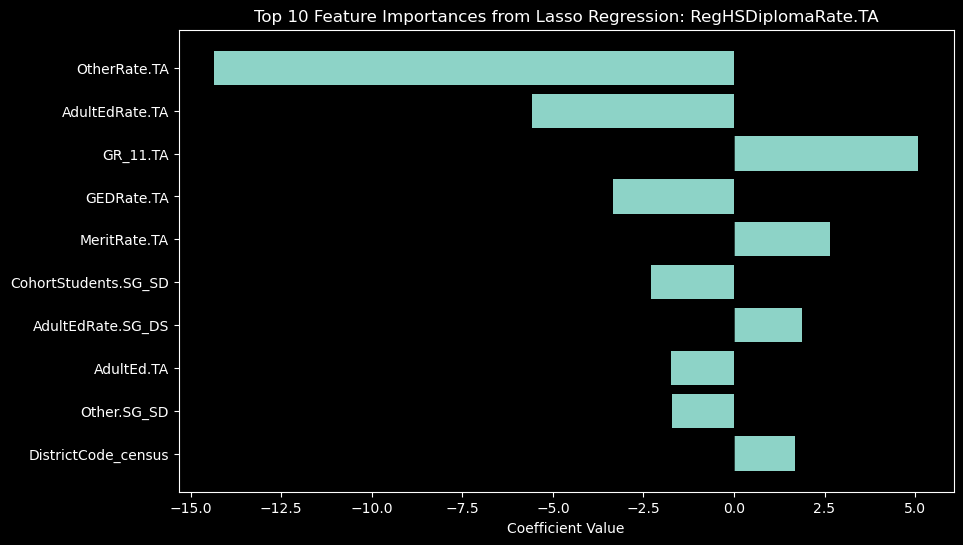

/opt/miniconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEdRate.GN_Z' 'BiliteracyRate.GN_Z' 'CPPRate.GN_Z'
 'ExemptionRate.GN_Z' 'GEDRate.GN_Z' 'MeritRate.GN_Z' 'OtherRate.GN_Z'
 'SPEDRate.GN_Z' 'StillEnrolledRate.GN_Z']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEdRate.GN_Z' 'BiliteracyRate.GN_Z' 'CPPRate.GN_Z'
 'ExemptionRate.GN_Z' 'GEDRate.GN_Z' 'MeritRate.GN_Z' 'OtherRate.GN_Z'
 'SPEDRate.GN_Z' 'StillEnrolledRate.GN_Z']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


R^2 Score: -0.00016201961536843612
Mean Squared Error: 653.4382682390572
Root Mean Squared Error: 25.562438620739165


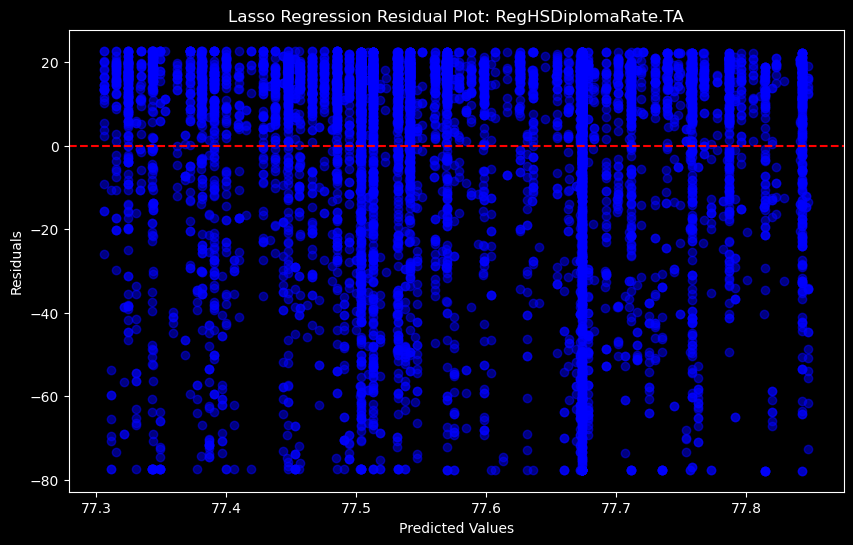

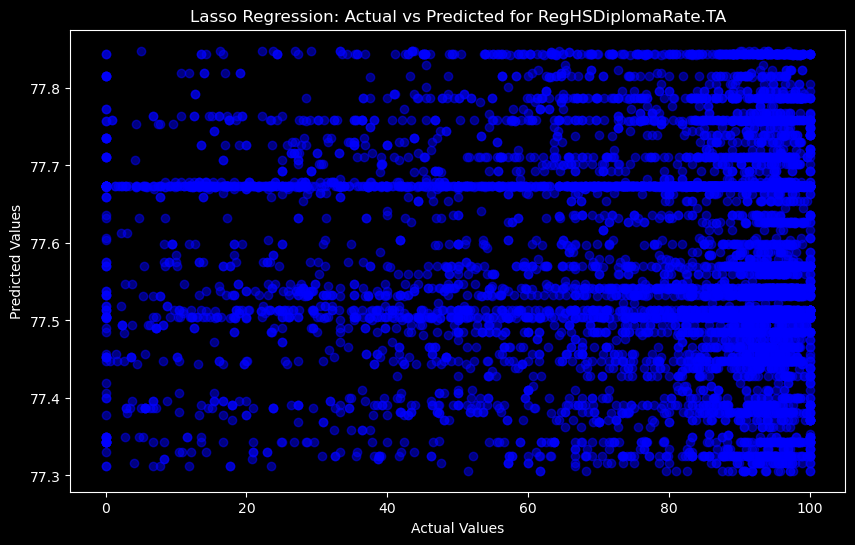

In [9]:
import modeling.utils.lasso as lasso_utils

target_column = "RegHSDiplomaRate.TA"
columns_to_drop = [col for col in merged.columns if col.startswith("UniReqs") or col.startswith("RegHSDiploma") or col.startswith("Dropout")]

X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    merged, target_column, columns_to_drop
)
lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)
print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")
lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEdRate.GN_Z' 'BiliteracyRate.GN_Z' 'CPPRate.GN_Z'
 'ExemptionRate.GN_Z' 'GEDRate.GN_Z' 'MeritRate.GN_Z' 'OtherRate.GN_Z'
 'SPEDRate.GN_Z' 'StillEnrolledRate.GN_Z']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


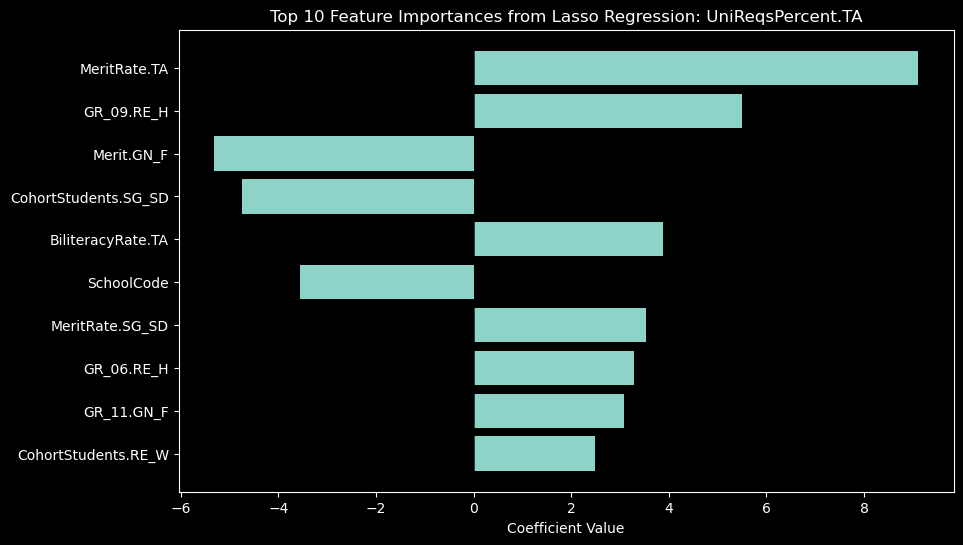

/opt/miniconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEdRate.GN_Z' 'BiliteracyRate.GN_Z' 'CPPRate.GN_Z'
 'ExemptionRate.GN_Z' 'GEDRate.GN_Z' 'MeritRate.GN_Z' 'OtherRate.GN_Z'
 'SPEDRate.GN_Z' 'StillEnrolledRate.GN_Z']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEdRate.GN_Z' 'BiliteracyRate.GN_Z' 'CPPRate.GN_Z'
 'ExemptionRate.GN_Z' 'GEDRate.GN_Z' 'MeritRate.GN_Z' 'OtherRate.GN_Z'
 'SPEDRate.GN_Z' 'StillEnrolledRate.GN_Z']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


R^2 Score: 0.005738428139674956
Mean Squared Error: 1021.0469796575894
Root Mean Squared Error: 31.95382574368192


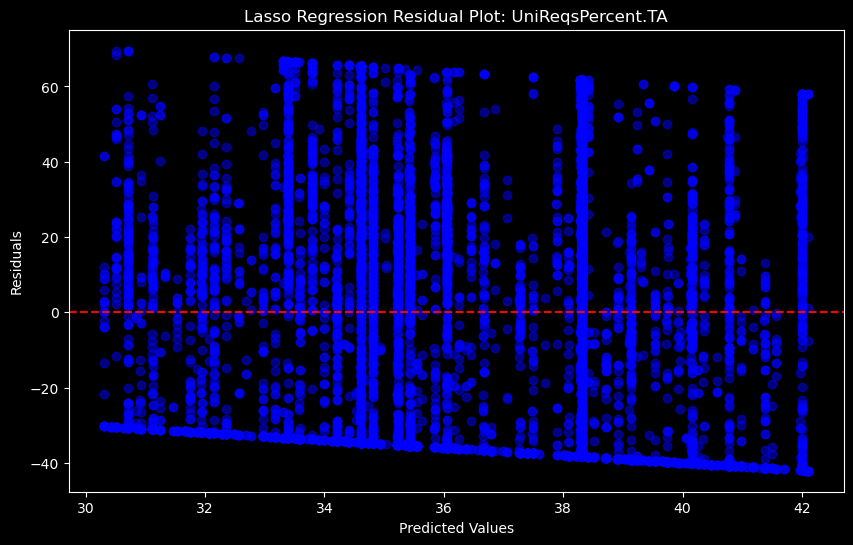

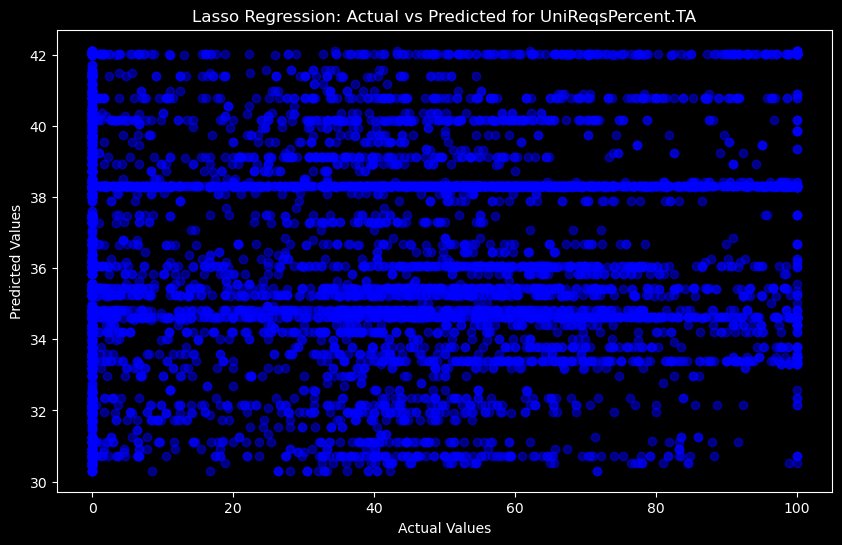

In [10]:
target_column = "UniReqsPercent.TA"

X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    merged, target_column, columns_to_drop
)

lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)
print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")

lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

# XGBoost


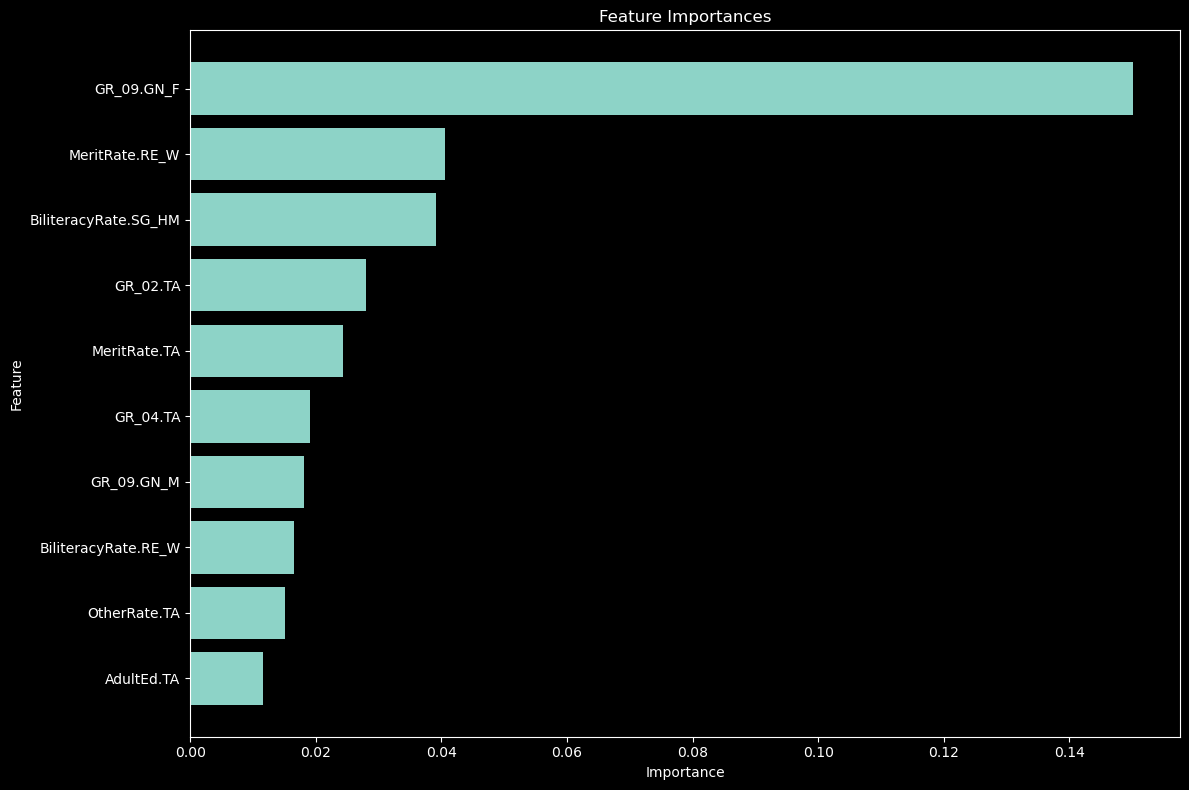

{'MSE': 133.91242024862873, 'RMSE': 11.57205341538954, 'MAE': 7.324395035263358, 'R^2': 0.8696005413064616}


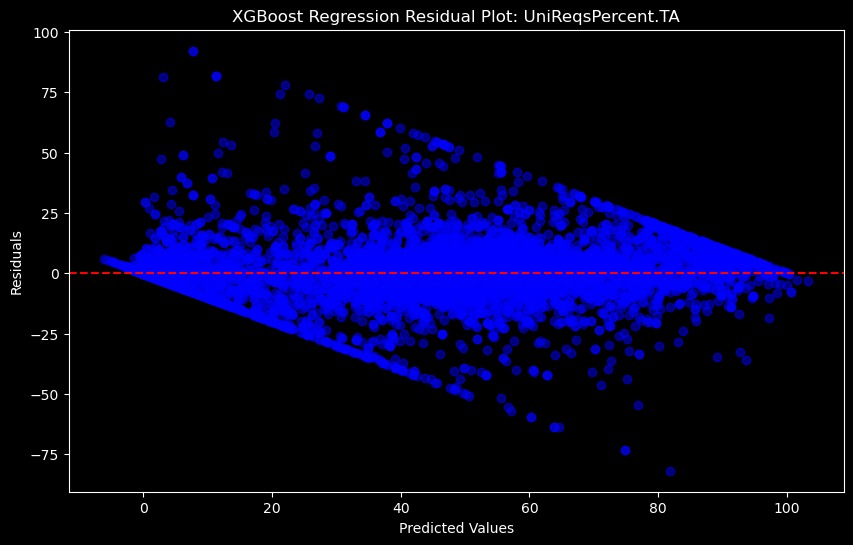

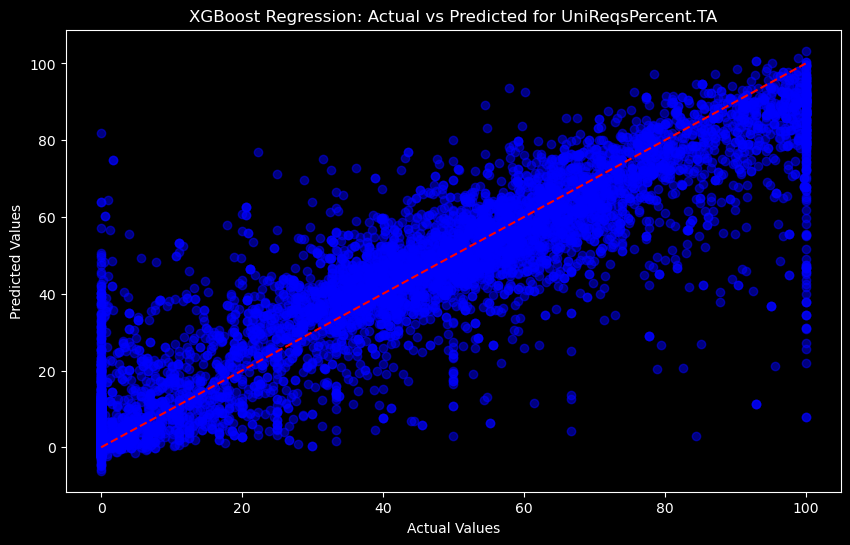

In [11]:
import modeling.utils.xgboost as xgb_utils

target_column = "UniReqsPercent.TA"
xgb_results = xgb_utils.train_xgboost_model(merged, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

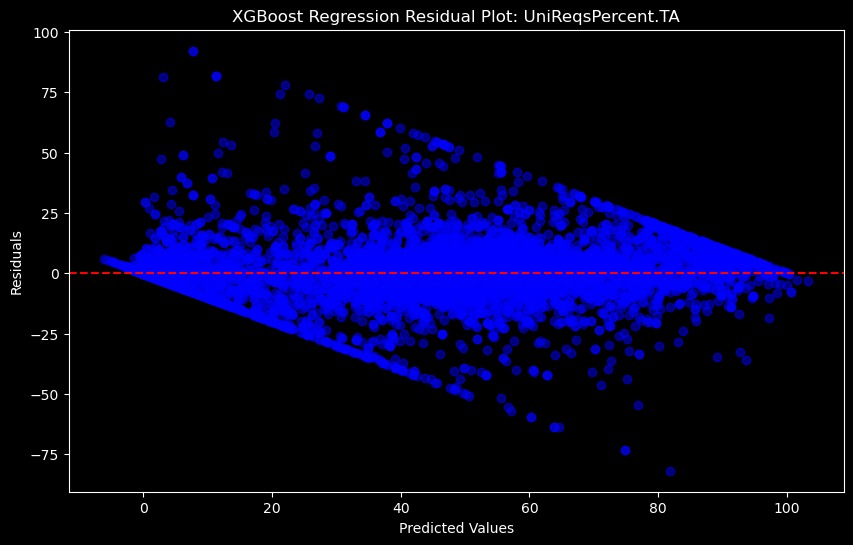

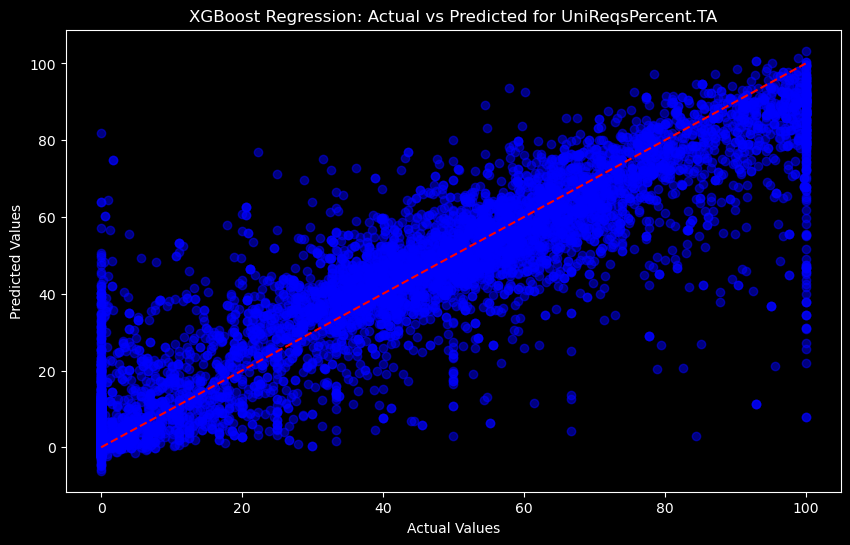

In [12]:
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

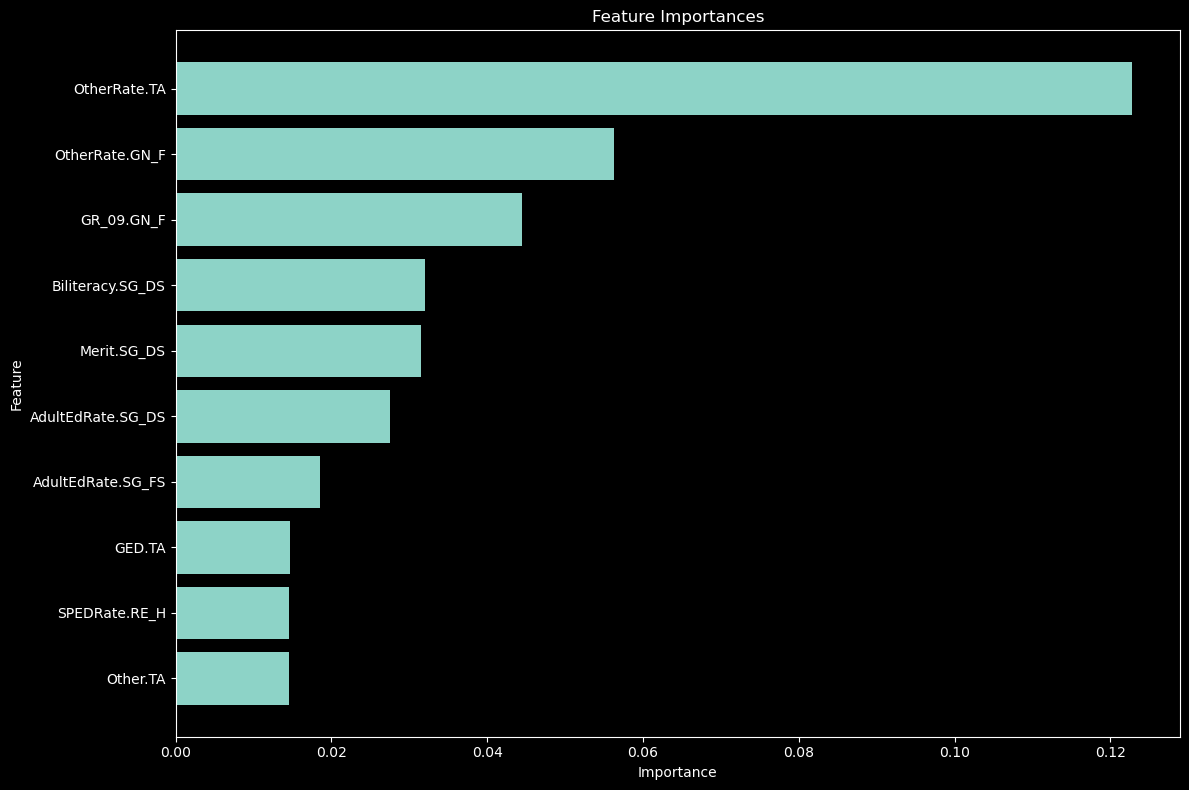

{'MSE': 40.29019222413536, 'RMSE': 6.347455570867382, 'MAE': 3.7683585494112344, 'R^2': 0.9383312518041256}


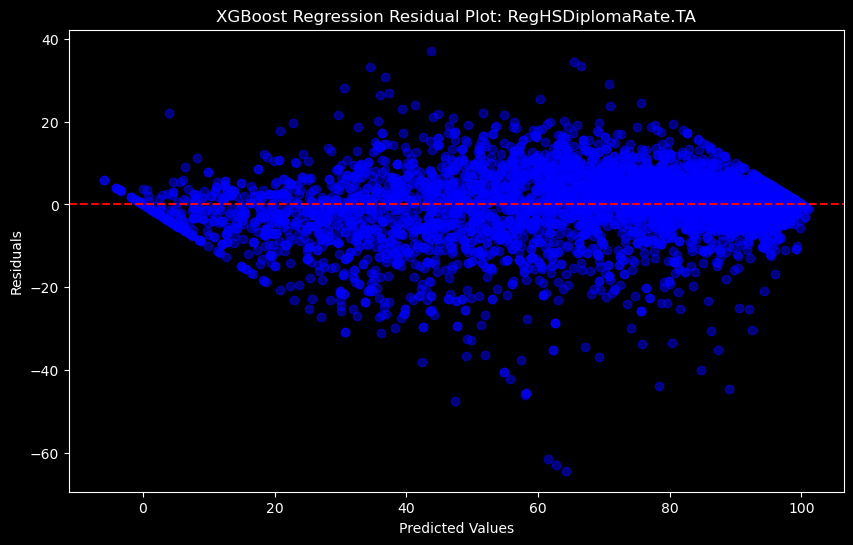

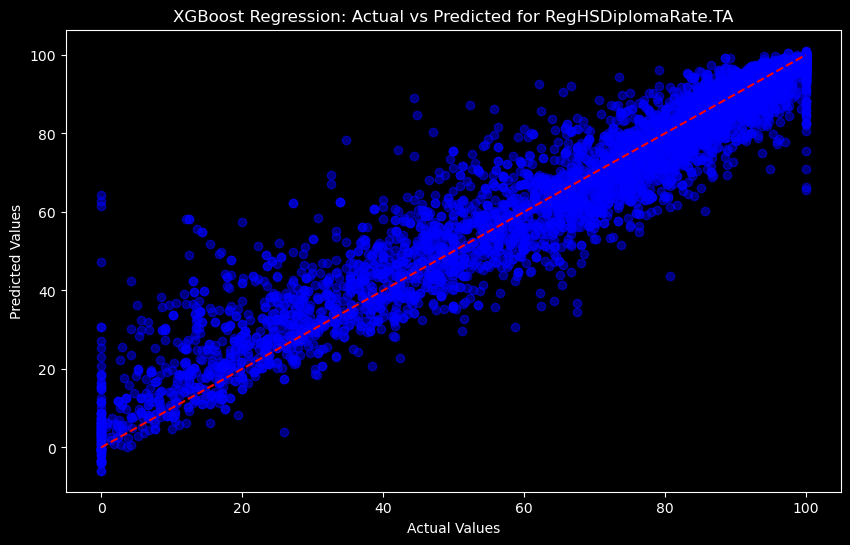

In [13]:
target_column = "RegHSDiplomaRate.TA"
xgb_results = xgb_utils.train_xgboost_model(merged, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

# Random Forest

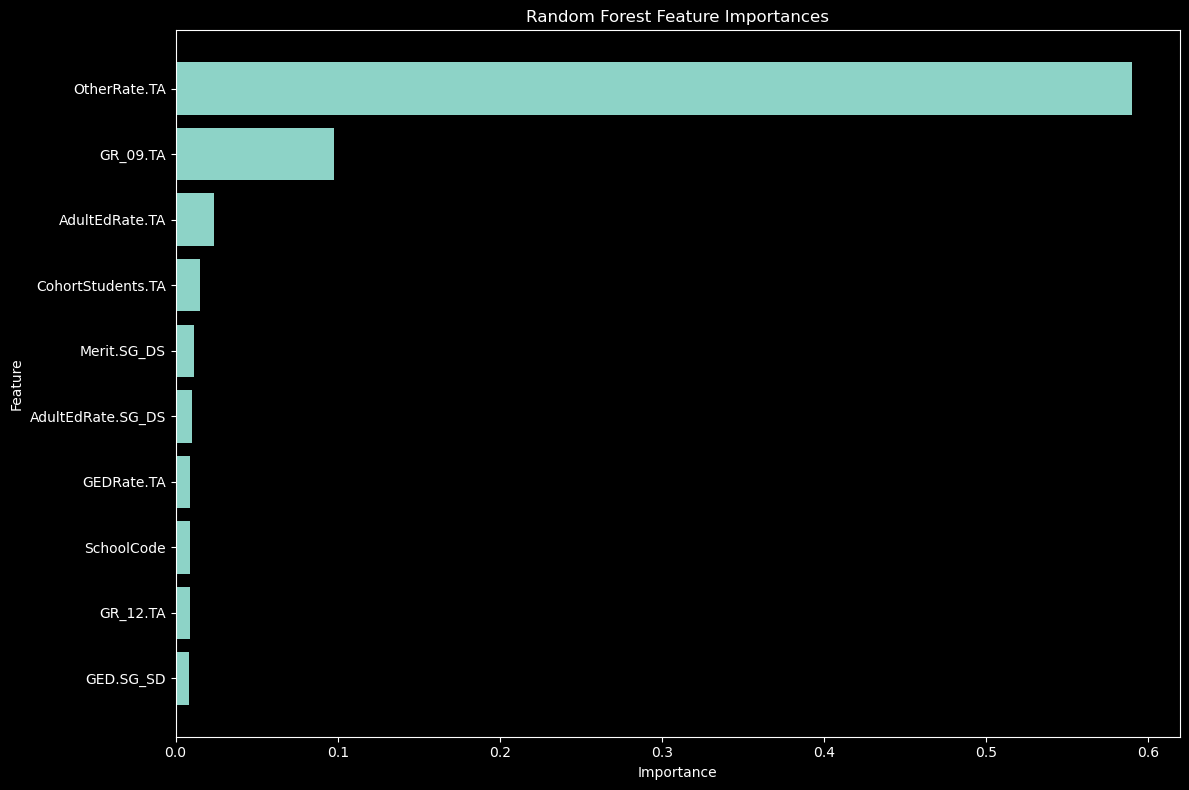

{'MSE': 15.340337773579277, 'RMSE': 3.9166743256976675, 'R²': 0.9734519384677119}


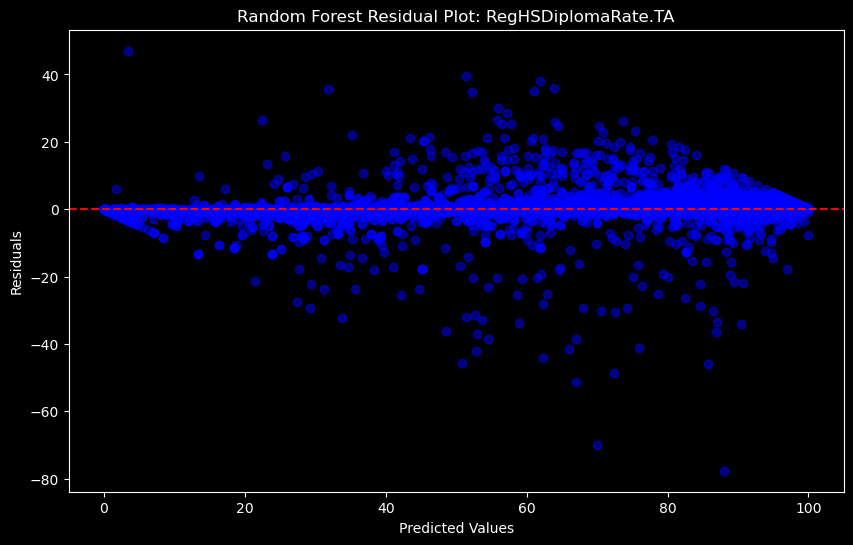

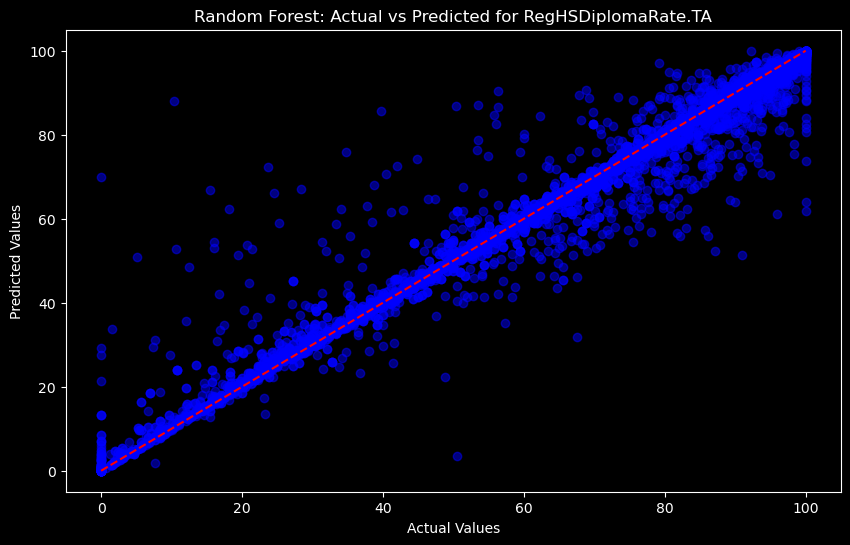

In [14]:
import modeling.utils.randomforest as rf_utils

merged_clean = merged.copy()
merged_clean = merged_clean.select_dtypes(include=[np.number])  # Keep only numeric columns

# Check for columns with all NaN values and drop them
null_columns = merged_clean.columns[merged_clean.isna().all()]
if len(null_columns) > 0:
	merged_clean = merged_clean.drop(columns=null_columns)

merged_clean = merged_clean.fillna(merged_clean.mean(numeric_only=True))

columns_to_drop_filtered = [col for col in columns_to_drop if col in merged_clean.columns]

rf_grad = rf_utils.train_random_forest_model(merged_clean, "RegHSDiplomaRate.TA", columns_to_drop_filtered)

print(rf_grad["metrics"])
rf_utils.plot_rf_residuals(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")
rf_utils.plot_rf_actual_predicted(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")

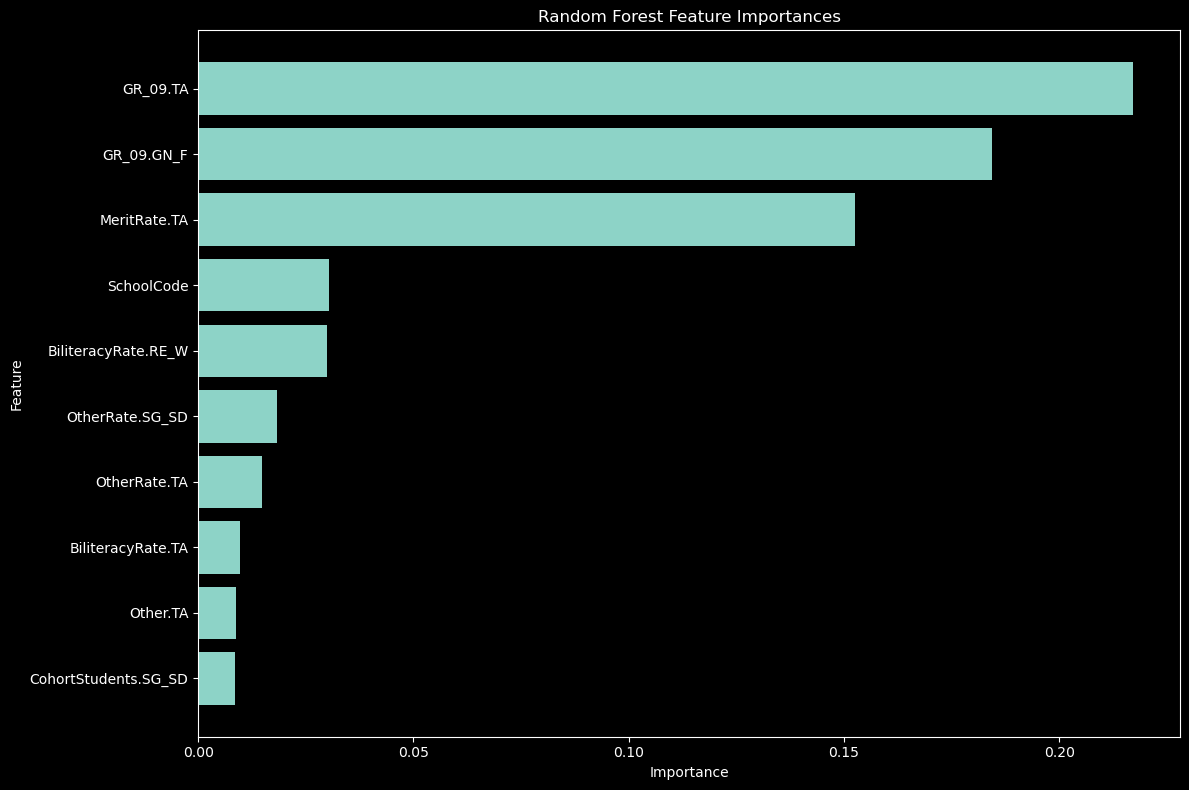

{'MSE': 34.58759149575932, 'RMSE': 5.881121618854631, 'R²': 0.9615455744728214}


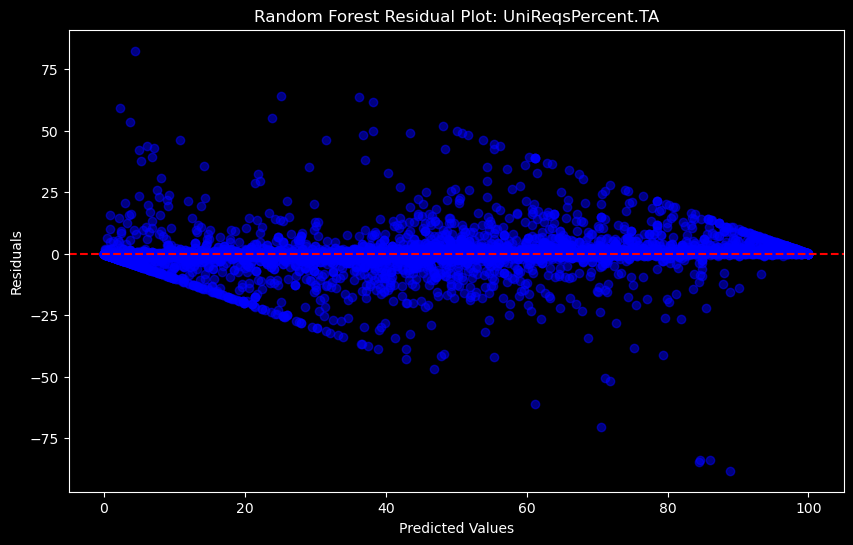

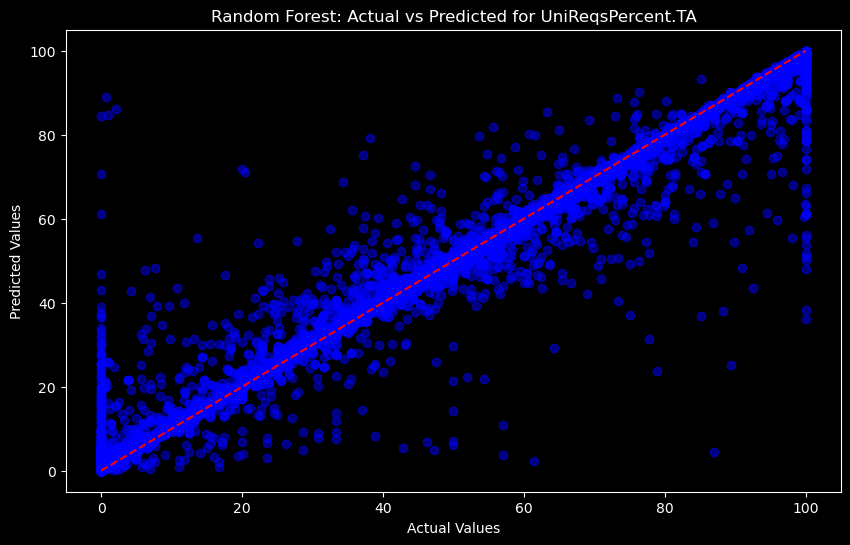

In [15]:
rf_uni = rf_utils.train_random_forest_model(merged_clean, "UniReqsPercent.TA", columns_to_drop_filtered)
print(rf_uni["metrics"])
rf_utils.plot_rf_residuals(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")
rf_utils.plot_rf_actual_predicted(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")

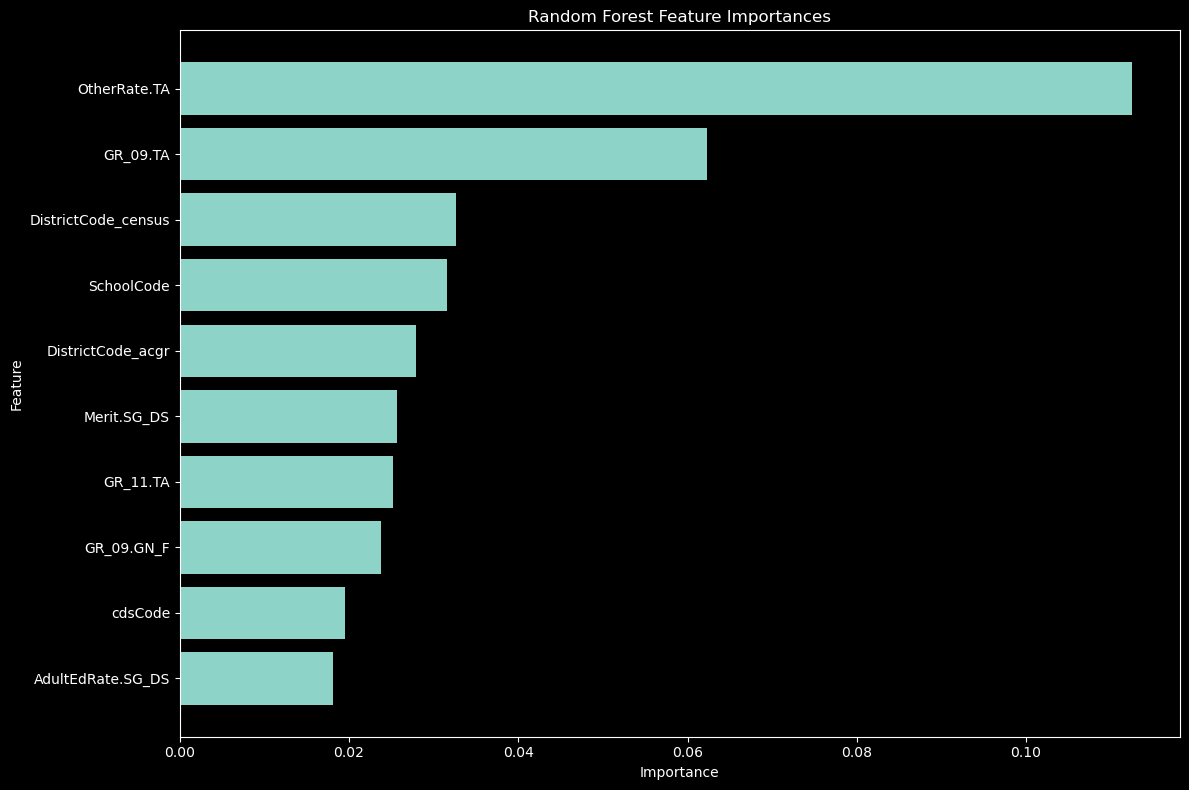

{'MSE': 15.89482493356721, 'RMSE': 3.986831440325413, 'R²': 0.905678938823963}


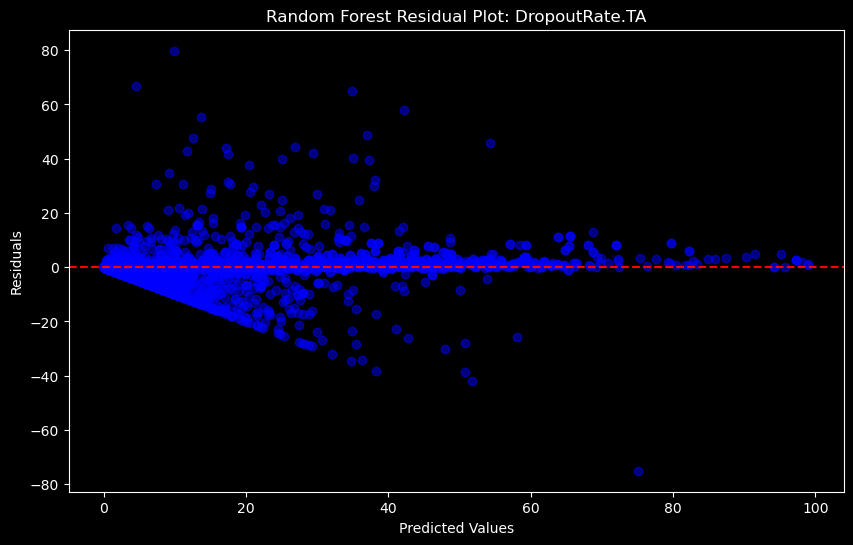

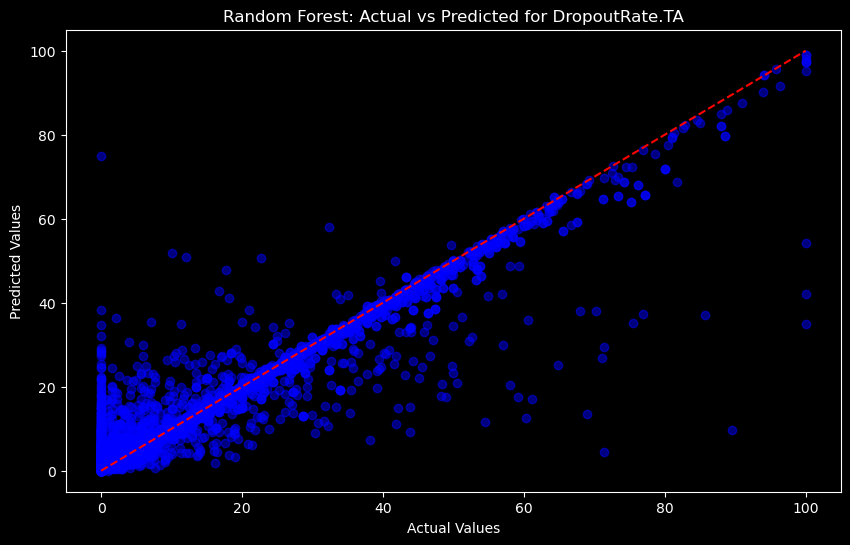

In [16]:
rf_dropout = rf_utils.train_random_forest_model(merged_clean, "DropoutRate.TA", columns_to_drop_filtered)
print(rf_dropout["metrics"])
rf_utils.plot_rf_residuals(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")
rf_utils.plot_rf_actual_predicted(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")

In [17]:
con.close()